# Config and Utils

In [ ]:
!git clone https://github.com/HensonChen/Font-diff.git

Cloning into 'Font-diff'...
remote: Enumerating objects: 15211, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 15211 (delta 9), reused 8 (delta 8), pack-reused 15201
Receiving objects: 100% (15211/15211), 116.04 MiB | 16.04 MiB/s, done.
Resolving deltas: 100% (1098/1098), done.
Updating files: 100% (12237/12237), done.


In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Imports and Macros
# Imports
# webscrapping & downloading
from bs4 import BeautifulSoup
from PIL import Image, ImageDraw, ImageFont, ImageOps
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random, torch, os, requests, copy, sys, numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt



In [ ]:
# ANALYSIS
d_fake_acc = []
d_real_acc = []
d_loss_acc = []
g_loss_acc = []

In [ ]:
# import math
# d_fake_acc2 = d_fake_acc[math.ceil(2*len(d_fake_acc)/3):]
# d_real_acc2 = d_real_acc[math.ceil(2*len(d_real_acc)/3):]
# d_loss_acc2 = d_loss_acc[math.ceil(2*len(d_loss_acc)/3):]
# g_loss_acc2 = g_loss_acc[math.ceil(2*len(g_loss_acc)/3):]

In [ ]:
class Config:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    RAW_DIR = "data/raw"
    TRAIN_DIR = "data/train"
    VAL_DIR = "data/val"
    EVAL_DIR = "data/eval"
    LEARNING_RATE = 2e-4
    BATCH_SIZE = 16
    NUM_WORKERS = 2
    IMAGE_SIZE = 64
    CHANNELS_IMG = 1
    L1_LAMBDA = 100
    LAMBDA_GP = 10
    NUM_EPOCHS = 200
    NUM_DATA = 5000
    LOAD_MODEL = False
    SAVE_MODEL = True
    CHECKPOINT_DISC = "disc.pth.tar"
    CHECKPOINT_GEN = "gen.pth.tar"

    both_transform = A.Compose(
        [A.Resize(width=IMAGE_SIZE, height=IMAGE_SIZE),], additional_targets={"image0": "image"},
    )

    # transform_only_input = A.Compose(
    #     [
    #         A.HorizontalFlip(p=0.5),
    #         A.ColorJitter(p=0.2),
    #         A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=1.0,),
    #         ToTensorV2(),
    #     ]
    # )

    # transform_only_mask = A.Compose(
    #     [
    #         A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=1.0,),
    #         ToTensorV2(),
    #     ]
    # )

In [ ]:
def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(Config.DEVICE), y.to(Config.DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x, folder + f"/input_{epoch}.png")
        save_image(y, folder + f"/label_{epoch}.png")
    gen.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=Config.DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr



# Dataset

In [ ]:
# modify directories
# !rm -r data
# !rm -r data/train
# !mkdir data/train
# !rm -r data/eval
# !mkdir data/eval



In [ ]:
# Download font 
!rm -r fonts
!mkdir fonts
!wget "https://fonts.google.com/download?family=Noto%20Sans%20TC"
!unzip "download?family=Noto Sans TC"
!mv NotoSansTC-Black.otf NotoSansTC-Bold.otf NotoSansTC-Light.otf NotoSansTC-Medium.otf NotoSansTC-Regular.otf NotoSansTC-Thin.otf fonts
!rm "download?family=Noto Sans TC" OFL.txt

rm: cannot remove 'fonts': No such file or directory
--2023-04-19 23:29:07--  https://fonts.google.com/download?family=Noto%20Sans%20TC
Resolving fonts.google.com (fonts.google.com)... 74.125.24.113, 74.125.24.100, 74.125.24.101, ...
Connecting to fonts.google.com (fonts.google.com)|74.125.24.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘download?family=Noto Sans TC’

download?family=Not     [   <=>              ]  28.42M  49.2MB/s    in 0.6s    

2023-04-19 23:29:10 (49.2 MB/s) - ‘download?family=Noto Sans TC’ saved [29796344]

Archive:  download?family=Noto Sans TC
  inflating: OFL.txt                 
  inflating: NotoSansTC-Thin.otf     
  inflating: NotoSansTC-Light.otf    
  inflating: NotoSansTC-Regular.otf  
  inflating: NotoSansTC-Medium.otf   
  inflating: NotoSansTC-Bold.otf     
  inflating: NotoSansTC-Black.otf    


In [ ]:
# Macros
# don't try this unless we're 99.999999% sure
# URL = "http://163.20.160.14/~word/modules/myalbum/viewcat.php?num=6576&cid=27"
URL = "http://163.20.160.14/~word/modules/myalbum/viewcat.php?num=" + str(Config.NUM_DATA) + "&cid=27"
PATH_FONT = "fonts/NotoSansTC-Medium.otf"
RAW_DATA = [] # filled after download

# Preprocessing image
IMG_LENGTH = Config.IMAGE_SIZE
FONT_NOTO = ImageFont.truetype(PATH_FONT, 130)

In [ ]:
page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")

def download_data_with_no_check():
    if not os.path.isdir(Config.RAW_DIR):
        os.mkdir(Config.RAW_DIR)
        os.mkdir(Config.TRAIN_DIR)
        os.mkdir(Config.VAL_DIR)
        os.mkdir(Config.EVAL_DIR)

  # get all raw image tags and save them to directory "zhiyong"
    def has_title(tag):
        return tag.name == "img" and tag.has_attr('title')
    raw_img_tags = soup.find_all(has_title)
    print(raw_img_tags)
    for raw_img_tag in raw_img_tags:
        if "http" in raw_img_tag.get('src'):
            lnk = raw_img_tag.get('src')
            title = raw_img_tag.get('title')
            with open(Config.RAW_DIR + "/" + title + '.gif', "wb") as f:
                f.write(requests.get(lnk).content)

    # loop through the titles and remove files with name length > 1
    for filename in os.listdir(Config.RAW_DIR):
        # here it's 5 because we include ".gif"
        if len(filename) > 5 and os.path.isfile(Config.RAW_DIR+"/"+filename) :
            f = os.path.join(Config.RAW_DIR, filename)
            os.remove(f)

  # !!TODO!! append all standardzed img to RAW_DATA here

def download_data():
    if os.path.exists(Config.RAW_DIR) and not os.path.isfile(Config.RAW_DIR):
        # Checking if the directory is empty or not
        lstdir = os.listdir(Config.RAW_DIR)
        if not lstdir or (len(lstdir) < 3 and lstdir[0][0] == '.'): # empty dir
            print("data dir emtpy, downloading data")
            download_data_with_no_check()
        else:
            print("data dir not empty, skipping download")
            pass
    else:
        print("data dir does not exist, creating dir and downloading data")
        os.mkdir('data')
        os.mkdir(Config.RAW_DIR)
        os.mkdir(Config.TRAIN_DIR)
        os.mkdir(Config.VAL_DIR)
        os.mkdir(Config.EVAL_DIR)
        download_data_with_no_check()

download_data()

data dir does not exist, creating dir and downloading data
[<img alt="斛" border="0" src="http://163.20.160.14/~word/uploads/photos/141758.gif" title="斛" width="140"/>, <img alt="料" border="0" src="http://163.20.160.14/~word/uploads/photos/141756.gif" title="料" width="140"/>, <img alt="料 (2)" border="0" src="http://163.20.160.14/~word/uploads/photos/141755.gif" title="料 (2)" width="140"/>, <img alt="斗" border="0" src="http://163.20.160.14/~word/uploads/photos/141753.gif" title="斗" width="140"/>, <img alt="斐" border="0" src="http://163.20.160.14/~word/uploads/photos/141750.gif" title="斐" width="140"/>, <img alt="敝" border="0" src="http://163.20.160.14/~word/uploads/photos/141733.gif" title="敝" width="140"/>, <img alt="敝 (2)" border="0" src="http://163.20.160.14/~word/uploads/photos/141732.gif" title="敝 (2)" width="140"/>, <img alt="教" border="0" src="http://163.20.160.14/~word/uploads/photos/141731.gif" title="教" width="140"/>, <img alt="敘" border="0" src="http://163.20.160.14/~word/uplo

In [ ]:
len(os.listdir(Config.RAW_DIR))

4799

In [ ]:
# (almost finished, just need to check how we want to 
# normalize/standardize our data)

# char to image
def char_to_image(c):
    im = Image.new("1", (140, 140), "white")
    d = ImageDraw.Draw(im)
    #d.line(((0, 70), (140, 70)), "black")
    #d.line(((70, 0), (70, 140)), "black")
    w, h = d.textsize(c, font=FONT_NOTO)
    h += int(h*0.21)
    d.text(((140 -w)/2, (140-h)/2), c, font=FONT_NOTO, fill="black")
    return im

# helper to return image of tensor (since colab couldn't show)
def tensor_to_image(tensor):
    transform = T.ToPILImage()
    img = transform(tensor)
    return img

def tensors_to_image(tensors):
    transform = T.ToPILImage()
    return transform(tensors[0]), transform(tensors[1])

# def of preprocessor to make the image 140 * 140
preprocess_raw = T.Compose([
    T.Grayscale(),
    T.Pad(100, 255),
    T.CenterCrop(140),
    T.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
    #   T.ToTensor(),
    # T.Normalize(mean=0, std=1) #???????
])

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

# data will be in pairs: eg. ['斐', tensor()]
# RAW_DATA =[]
i = 0
for filename in os.listdir(Config.RAW_DIR):
    path = Config.RAW_DIR + "/" + filename
    if os.path.isfile(path):
        # we pass in the first character of filename (eg. 敗.gif)
        img = char_to_image(filename[0])
        a = preprocess_raw(img)
        b = preprocess_raw(Image.open(path))
        img_to_add = get_concat_h(a, b)

        if i < 0.8 * Config.NUM_DATA:
            img_to_add.save(Config.TRAIN_DIR + "/" + str(i) + '.png')
        else:
            img_to_add.save(Config.VAL_DIR + "/" + str(i) + '.png')
        i += 1

        # RAW_DATA.append([a, b])


# a, b = tensors_to_image(RAW_DATA[0])

In [ ]:
preprocess_train = T.Compose([
    T.Grayscale(Config.CHANNELS_IMG),
    T.ToTensor(),
    # T.Normalize(mean=0, std=1) #???????
])

class ZhiyongDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = Image.open(img_path)
        image = preprocess_train(image)
        # image = preprocess_train(image)[0]
        # image = image.unsqueeze(dim=2)


        # print("2. image: ", image.shape)
        # input_image = image[:, :Config.IMAGE_SIZE, :]
        # target_image = image[:, Config.IMAGE_SIZE:, :]
        input_image = image[:, :, :Config.IMAGE_SIZE]
        target_image = image[:, :, Config.IMAGE_SIZE:]
        # print("3. input image: ", input_image.shape, ", target_image: ", target_image.shape)

        # augmentations = Config.both_transform(image=input_image, image0=target_image)
        # input_image = augmentations["image"]
        # target_image = augmentations["image0"]

        # input_image = Config.transform_only_input(image=input_image)["image"]
        # target_image = Config.transform_only_mask(image=target_image)["image"]

        return input_image, target_image


if __name__ == "__main__":
    dataset = ZhiyongDataset("data/train/")
    loader = DataLoader(dataset, batch_size=18)
    for x, y in loader:
        save_image(x, "x.png")
        save_image(y, "y.png")


# Discriminator and Generator

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, kernel_size=4):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
feature_list_original_70 = [64, 128, 256, 512]
feature_list_original_16 = [64, 128]
feature_list_70 = [32, 64, 128, 256]
feature_list_16 = [32, 64]
feature_list_1 = [32, 64]

class Discriminator(nn.Module):
    def __init__(self, in_channels=Config.CHANNELS_IMG, features=feature_list_70, is_1_by_1_disc=False):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels * 2,
                features[0],
                kernel_size=1 if is_1_by_1_disc else 4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2, kernel_size=1 if is_1_by_1_disc else 4),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=1 if is_1_by_1_disc else 4, stride=1, padding=1, padding_mode="reflect"
            ),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        x = self.model(x)
        return x

def test():
    x = torch.randn((1, 1, Config.IMAGE_SIZE, Config.IMAGE_SIZE))
    y = torch.randn((1, 1, Config.IMAGE_SIZE, Config.IMAGE_SIZE))
    model = Discriminator(in_channels=1)
    preds = model(x, y)
    print(model)
    print(preds.shape)


test()

Discriminator(
  (initial): Sequential(
    (0): Conv2d(2, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): Conv2d(64, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  )
)
torch.Size([1, 1, 30, 30])


In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels=1, features=64):
        super().__init__()
        # self.initial_down = nn.Sequential(
        #     nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
        #     nn.LeakyReLU(0.2),
        # )
        # self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        # self.down2 = Block(
        #     features * 2, features * 4, down=True, act="leaky", use_dropout=False
        # )
        # self.down3 = Block(
        #     features * 4, features * 8, down=True, act="leaky", use_dropout=False
        # )
        # self.down4 = Block(
        #     features * 8, features * 8, down=True, act="leaky", use_dropout=False
        # )
        # self.down5 = Block(
        #     features * 8, features * 8, down=True, act="leaky", use_dropout=False
        # )
        # self.down6 = Block(
        #     features * 8, features * 8, down=True, act="leaky", use_dropout=False
        # )
        # self.bottleneck = nn.Sequential(
        #     nn.Conv2d(features * 8, features * 8, kernel_size=4, stride=2, padding=1), 
        #     nn.ReLU()
        # )

        # self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        # self.up2 = Block(
        #     features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        # )
        # self.up3 = Block(
        #     features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        # )
        # self.up4 = Block(
        #     features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        # )
        # self.up5 = Block(
        #     features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        # )
        # self.up6 = Block(
        #     features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        # )
        # self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        # self.final_up = nn.Sequential(
        #     nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
        #     nn.Sigmoid(),
        # )

        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, kernel_size=4, stride=2, padding=1), 
            nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        

    def forward(self, x):
        # d1 = self.initial_down(x)
        # d2 = self.down1(d1)
        # d3 = self.down2(d2)
        # d4 = self.down3(d3)
        # d5 = self.down4(d4)
        # d6 = self.down5(d5)
        # d7 = self.down6(d6)
        # print(d7.shape)
        # bottleneck = self.bottleneck(d7)
        # up1 = self.up1(bottleneck)
        # up2 = self.up2(torch.cat([up1, d7], 1))
        # up3 = self.up3(torch.cat([up2, d6], 1))
        # up4 = self.up4(torch.cat([up3, d5], 1))
        # up5 = self.up5(torch.cat([up4, d4], 1))
        # up6 = self.up6(torch.cat([up5, d3], 1))
        # up7 = self.up7(torch.cat([up6, d2], 1))
        # return self.final_up(torch.cat([up7, d1], 1))

        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        # d6 = self.down5(d5)
        # d7 = self.down6(d6)
        # print(d6.shape)
        bottleneck = self.bottleneck(d5)
        up1 = self.up1(bottleneck)
        # up2 = self.up2(torch.cat([up1, d7], 1))
        # up3 = self.up3(torch.cat([up1, d6], 1))
        up4 = self.up4(up1)
        up5 = self.up5(up4)
        up6 = self.up6(up5)
        up7 = self.up7(up6)
        return self.final_up(up7)



def test():
    x = torch.randn((5, 1, Config.IMAGE_SIZE, Config.IMAGE_SIZE))
    model = Generator(in_channels=1, features=64)
    preds = model(x)
    print(preds.shape)

# test()

# Train

In [ ]:
torch.backends.cudnn.benchmark = True

def train_fn(
    disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler,
):
    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x = x.to(Config.DEVICE)
        y = y.to(Config.DEVICE)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2
            d_loss_acc.append(D_loss)

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * Config.L1_LAMBDA
            G_loss = G_fake_loss + L1
            g_loss_acc.append(G_loss)

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            avg_d_real = torch.sigmoid(D_real).mean().item()
            avg_d_fake = torch.sigmoid(D_fake).mean().item()
            loop.set_postfix(
                D_real=avg_d_real,
                D_fake=avg_d_fake,
            )
            d_real_acc.append(avg_d_real)
            d_fake_acc.append(avg_d_fake)

In [ ]:
def main():
    disc = Discriminator(in_channels=Config.CHANNELS_IMG).to(Config.DEVICE)
    gen = Generator(in_channels=Config.CHANNELS_IMG, features=32).to(Config.DEVICE)
    opt_disc = optim.Adam(disc.parameters(), lr=Config.LEARNING_RATE, betas=(0.5, 0.999),)
    opt_gen = optim.Adam(gen.parameters(), lr=Config.LEARNING_RATE, betas=(0.5, 0.999))
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()
    # L1_LOSS = nn.MSELoss()

    if Config.LOAD_MODEL:
        load_checkpoint(
            Config.CHECKPOINT_GEN, gen, opt_gen, Config.LEARNING_RATE,
        )
        load_checkpoint(
            Config.CHECKPOINT_DISC, disc, opt_disc, Config.LEARNING_RATE,
        )

    train_dataset = ZhiyongDataset(root_dir=Config.TRAIN_DIR)
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=Config.NUM_WORKERS,
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    val_dataset = ZhiyongDataset(root_dir=Config.VAL_DIR)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

    for epoch in range(Config.NUM_EPOCHS):
        train_fn(
            disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler,
        )

        if Config.SAVE_MODEL and epoch % 5 == 0:
            save_checkpoint(gen, opt_gen, filename=Config.CHECKPOINT_GEN)
            save_checkpoint(disc, opt_disc, filename=Config.CHECKPOINT_DISC)

        save_some_examples(gen, val_loader, epoch, folder=Config.EVAL_DIR)
    



main()

100%|██████████| 90/90 [00:02<00:00, 38.51it/s, D_fake=0.375, D_real=0.353]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 39.44it/s, D_fake=0.297, D_real=0.767]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 39.76it/s, D_fake=0.142, D_real=0.845]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 39.34it/s, D_fake=0.446, D_real=0.69]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 37.43it/s, D_fake=0.176, D_real=0.74]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 38.73it/s, D_fake=0.475, D_real=0.681]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 37.99it/s, D_fake=0.142, D_real=0.9]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 38.09it/s, D_fake=0.419, D_real=0.635]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 34.95it/s, D_fake=0.431, D_real=0.613]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 35.78it/s, D_fake=0.331, D_real=0.656]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 38.64it/s, D_fake=0.141, D_real=0.833]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 36.20it/s, D_fake=0.206, D_real=0.816]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 37.48it/s, D_fake=0.129, D_real=0.813]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 37.08it/s, D_fake=0.389, D_real=0.362]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 36.62it/s, D_fake=0.301, D_real=0.759]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 36.85it/s, D_fake=0.0165, D_real=0.965]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 37.42it/s, D_fake=0.0797, D_real=0.926]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 36.99it/s, D_fake=0.0674, D_real=0.919]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 37.49it/s, D_fake=0.0648, D_real=0.858]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 38.46it/s, D_fake=0.121, D_real=0.788]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 37.08it/s, D_fake=0.0212, D_real=0.954]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 37.27it/s, D_fake=0.217, D_real=0.776]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 36.25it/s, D_fake=0.109, D_real=0.787]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 37.71it/s, D_fake=0.0603, D_real=0.872]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 36.10it/s, D_fake=0.0205, D_real=0.963]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 35.94it/s, D_fake=0.0684, D_real=0.922]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 36.95it/s, D_fake=0.015, D_real=0.964]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 37.06it/s, D_fake=0.0438, D_real=0.874]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 36.71it/s, D_fake=0.0177, D_real=0.957]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 37.65it/s, D_fake=0.0258, D_real=0.974]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 37.93it/s, D_fake=0.203, D_real=0.832]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 38.19it/s, D_fake=0.0214, D_real=0.951]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 35.97it/s, D_fake=0.0271, D_real=0.932]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 38.06it/s, D_fake=0.828, D_real=0.427]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 36.70it/s, D_fake=0.0458, D_real=0.93]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 37.70it/s, D_fake=0.0403, D_real=0.774]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 37.15it/s, D_fake=0.0551, D_real=0.882]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 37.61it/s, D_fake=0.0191, D_real=0.973]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 36.98it/s, D_fake=0.04, D_real=0.965]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 37.91it/s, D_fake=0.0182, D_real=0.973]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 90/90 [00:02<00:00, 38.09it/s, D_fake=0.000125, D_real=0.986]


# Plots

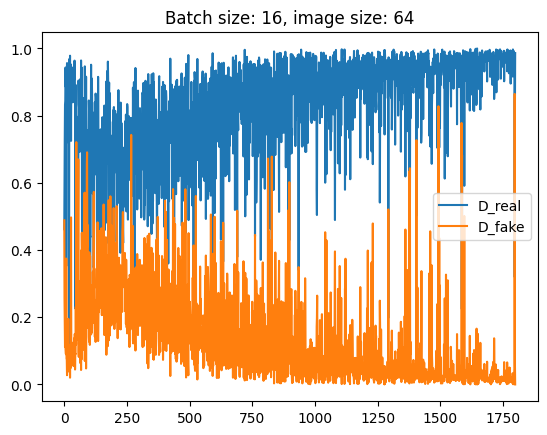

In [ ]:
def plot_d_real_fake():
    x_for_acc = [i for i in range(len(d_real_acc))]
    plt.plot(x_for_acc, d_real_acc, label = "D_real")
    # plotting the line 2 points 
    plt.plot(x_for_acc, d_fake_acc, label = "D_fake")
    
    # giving a title to my graph
    plt.title('Batch size: ' + str(Config.BATCH_SIZE) + ', image size: '+ str(Config.IMAGE_SIZE))
    
    # show a legend on the plot
    plt.legend()
    
    # function to show the plot
    plt.show()

plot_d_real_fake()

min loss is:  tensor(8.3990) at  tensor(16998)


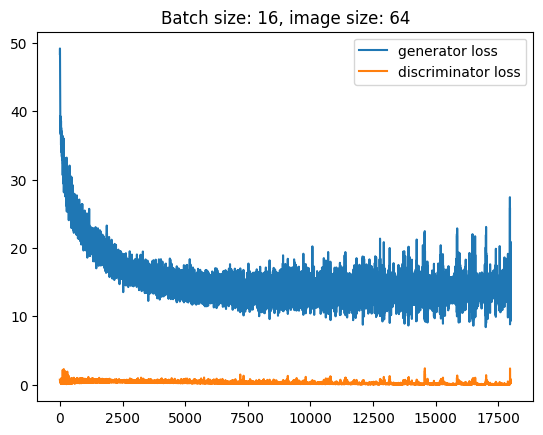

In [ ]:
def plot_loss():
    g_loss_acc_2 = torch.tensor(g_loss_acc, device="cpu")
    d_loss_acc_2 = torch.tensor(d_loss_acc, device="cpu")
    x_for_acc = [i for i in range(len(g_loss_acc_2))]
    plt.plot(x_for_acc, g_loss_acc_2, label="generator loss")
    plt.plot(x_for_acc, d_loss_acc_2, label="discriminator loss")
    # print("min Generator loss: ", np.min(g_loss_acc_2), ", min Discriminator loss: ", np.min(d_loss_acc_2))

    plt.title('Batch size: ' + str(Config.BATCH_SIZE) + ', image size: '+ str(Config.IMAGE_SIZE))
    plt.legend()
    plt.show()

g_loss_acc_2 = torch.tensor(g_loss_acc, device="cpu")
print("min loss is: ", torch.min(g_loss_acc_2), "at ", torch.argmin(g_loss_acc_2))
plot_loss()

In [ ]:
!zip -r /content/eval.zip /content/data/eval

In [ ]:
from google.colab import files
files.download("/content/eval.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!rm -r /content/data/eval/*